In [9]:
import numpy as np
import os,sys,glob,json
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc

import healpy as hp

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord

import hasasia.sensitivity as hassen
import hasasia.sim as hassim
import hasasia.skymap as hassky

from enterprise.pulsar import Pulsar as ePulsar

In [2]:
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})

In [3]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('nanograv')
top_dir = "/".join(splt_path[0:top_path_idx+1])

pta_sim_dir = top_dir + '/pta_sim/pta_sim/'
sys.path.insert(0,pta_sim_dir)
import noise

psrs_wn_only_dir = top_dir + '/NANOGrav/BackgroundInjections/FakePTA/'

noise_11yr_dir = top_dir + '/NANOGrav/BackgroundInjections/nano11/noisefiles_new/'
psrlist_11yr_file = top_dir + '/NANOGrav/BackgroundInjections/nano11/psrlist_Tg3yr.txt'

psrs_mdc2_dir = top_dir + '/NANOGrav/MDC2/mdc2/group1/dataset_1a/'
noise_mdc2_file =  top_dir + '/NANOGrav/MDC2/mdc2/group1/group1_psr_noise.json'

pardir = psrs_mdc2_dir
timdir = psrs_mdc2_dir

noisedir = noise_mdc2_file

pars = sorted(glob.glob(pardir+'*.par'))
tims = sorted(glob.glob(timdir+'*.tim'))
#noise_files = sorted(glob.glob(noisedir+'*.txt'))
noise_file = noise.load_noise_files(noisepath=noise_mdc2_file)

encoding = 'utf-8'
psr_list_bytes = np.loadtxt(psrlist_11yr_file,dtype='S42')
psrlist = []
for psr in psr_list_bytes:
    psrlist.append(psr.decode(encoding))

In [4]:
ePsrs = []
for par,tim in zip(pars,tims):
    ePsr = ePulsar(par, tim,  ephem='DE436')
    ePsrs.append(ePsr)
    print('\rPSR {0} complete'.format(ePsr.name),end='',flush=True)

PSR J0030+0451 complete

PSR J0034-0534 complete

PSR J0613-0200 complete

PSR J0711-6830 complete

PSR J0751+1807 complete

PSR J1603-7202 complete

PSR J1939+2134 complete

PSR J1944+0907 complete

PSR J2145-0750 complete

PSR J2317+1439 complete

In [18]:
def make_corr(psr,noisedict):
    N = psr.toaerrs.size
    corr = np.zeros((N,N))
    _, _, U = hassen.quantize_fast(psr.toas,psr.toaerrs,dt=1)
    u = np.matmul(U,U.T)
    keys = [ky for ky in noisedict.keys() if psr.name in ky]
    #backends = np.unique(psr.flags['f'])
    sigma_sqr = np.zeros(N)
    ecorrs = np.zeros(N)
    """
    for be in backends:
        mask = np.where(ePsr.flags['f']==be)
        key_ec = '{0}_{1}_log10_{2}'.format(psr.name,be,'ecorr')
        ecorrs[mask] = np.ones_like(mask) * (10**noise[key_ec])**2
        key_ef = '{0}_{1}_{2}'.format(psr.name,be,'efac')
        key_eq = '{0}_{1}_log10_{2}'.format(psr.name,be,'equad')
        sigma_sqr[mask] = (noise[key_ef]**2 * (psr.toaerrs[mask]**2)
                           + (10**noise[key_eq])**2)
    """
    corr = np.diag(sigma_sqr) + np.diag(u*ecorrs**2)
    return corr

In [19]:
Tspan = hassen.get_Tspan(ePsrs)

In [20]:
#Get Noise Values
with open(noisedir, 'rb') as fin:
    noise_json =json.load(fin)

noiseparams = noise.handle_noise_parameters(noise_json)

In [21]:
fyr = 1/(365.25*24*3600)
freqs = np.logspace(np.log10(1/(5*Tspan)),np.log10(2e-7),600)

In [24]:
psrs = []
thin = 10
for ePsr in ePsrs:
    corr = make_corr(ePsr,noiseparams)[::thin,::thin]
    plaw = hassen.red_noise_powerlaw(A=9e-16, gamma=13/3., freqs=freqs)
    """
    if ePsr.name in rn_psrs.keys():
        Amp, gam = rn_psrs[ePsr.name]
        plaw += hassen.red_noise_powerlaw(A=Amp, gamma=gam, freqs=freqs)
    """
    corr += hassen.corr_from_psd(freqs=freqs, psd=plaw,
                               toas=ePsr.toas[::thin])
    psr = hassen.Pulsar(toas=ePsr.toas[::thin],
                      toaerrs=ePsr.toaerrs[::thin],
                      phi=ePsr.phi,theta=ePsr.theta,
                      N=corr, designmatrix=ePsr.Mmat[::thin,:])
    psr.name = ePsr.name
    psrs.append(psr)
    del ePsr
    print('\rPSR {0} complete'.format(psr.name),end='',flush=True)

PSR J2317+1439 complete

In [29]:
specs = []
for p in psrs:
    sp = hassen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    specs.append(sp)
    print('\rPSR {0} complete'.format(p.name),end='',flush=True)

PSR J2317+1439 complete

INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


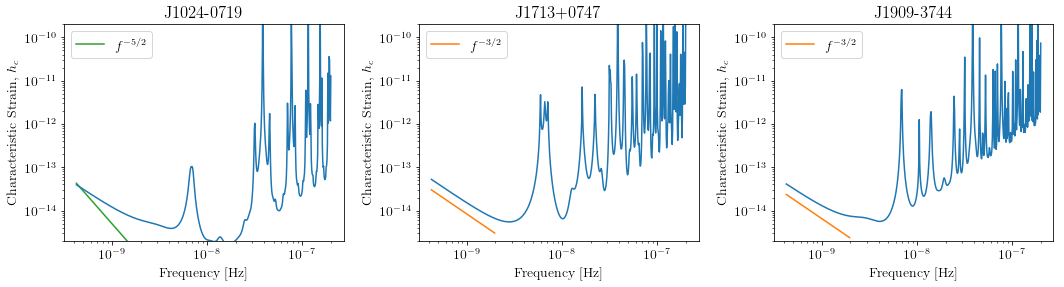

In [30]:
fig=plt.figure(figsize=[15,45])
j = 1
names = ['B1937+21','J0340+4130','J1024-0719',
         'J1713+0747','J1853+1303','J1909-3744',]
for sp,p in zip(specs,psrs):
    if p.name in names:
        fig.add_subplot(12,3,j)
        a = sp.h_c[0]/2*1e-14
        if p.name == 'J1024-0719':
            alp = -5/2
            a *= 8e-10
            plt.loglog(sp.freqs[:150],a*(sp.freqs[:150])**(alp),
                       color='C2',label=r'$f^{-5/2}$')
        else:
            alp = -3/2
            plt.loglog(sp.freqs[:150],a*(sp.freqs[:150])**(alp),
                       color='C1',label=r'$f^{-3/2}$')
        plt.ylim(2e-15,2e-10)
        plt.loglog(sp.freqs,sp.h_c, color='C0')
        plt.rc('text', usetex=True)
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Characteristic Strain, $h_c$')
        plt.legend(loc='upper left')
        plt.title(p.name)
        j+=1
fig.tight_layout()
plt.show()
plt.close()